In [1]:
"""
author: cresswellclayec

example SIRD simulation for a given set of parameters
You can re-rerun an individual simulation of annoy of the given models form the paper

Requisite modules: 
    - newSIRD.py
    - summary.py
"""

# Import necessary tools
from newSIRD import SIRD_pool,  produce_amount_keys
from newSIRD_analysis import SIRD_summary


from itertools import product
from multiprocessing import Pool
import pandas as pd
import numpy as np
import bz2
import pickle as pkl
import sys, os
import time
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

In [2]:
#--- Dictionary of paper parameters ---#
# function for slicing/passing model parameters to simulation
def my_product(inp):
    return [dict(zip(inp.keys(), values)) for values in product(*inp.values())]

# Define Parameter set:
param_lists = {'inf_rate':[1/8.,1/10.,1/12.,1/14.,1/16.,1/18.,1/20.],\
               'rec_rate':[1/10.,1/13.,1/16.,1/19.,1/22.,1/25.,1/28.,1/31.],\
               'death_rate':[1/500.,1/750.,1/1000.,1/1250.,1/1500.,1/1750.,1/2000.],\
               'scale_pop_dens':[2.,2.5,3.,3.5,4.,4.5,5.,5.5],\
               'scale_med_age':[0.5,0.65,0.8,0.95,1.1,1.25],\
               'age_increase':[5.4,5.5,5.6],\
               'N':[1e5,9e4],\
               'N_init':[1],\
               'sus_age':[0.],\
               'max_age':[100.],\
               'n_sims':[40],\
               'tmax':[100],\
               'tplus':[15],\
               'time_to_fit':[15]}

# list of possible models
model_list = my_product(param_lists)

# parameter model index
index = 10
random_seed = index
#--------------------------------------#


#--- Select model from paper model list ---#
#model = model_list[index]
# or: define your own model
model_death =  {'inf_rate': 0.1, 'rec_rate': 0.0774, 'death_rate': 0.002, 'scale_pop_dens': 2.0, \
 'scale_med_age': 0.65, 'age_increase': 5.5, 'N': 100000.0, 'N_init': 1, 'sus_age': 0.0,\
 'max_age': 100.0, 'n_sims': 40, 'tmax': 100, 'tplus': 15, 'time_to_fit': 15}
model_life =  {'inf_rate': 1/16., 'rec_rate': 1/19., 'death_rate': 0.0006, 'scale_pop_dens': 3.5, \
 'scale_med_age': 0.65, 'age_increase': 5.4, 'N': 100000.0, 'N_init': 1, 'sus_age': 0.0,\
 'max_age': 100.0, 'n_sims': 40, 'tmax': 100, 'tplus': 15, 'time_to_fit': 15}

model = model_life

print("Model %d of %d :\n"%(index,len(model_list)),model)
#------------------------------------------#



Model 10 of 112896 :
 {'inf_rate': 0.0625, 'rec_rate': 0.05263157894736842, 'death_rate': 0.0006, 'scale_pop_dens': 3.5, 'scale_med_age': 0.65, 'age_increase': 5.4, 'N': 1000.0, 'N_init': 1, 'sus_age': 0.0, 'max_age': 100.0, 'n_sims': 40, 'tmax': 100, 'tplus': 15, 'time_to_fit': 15}


In [3]:
# Run simulation

filename =  "model_" + str(index) 
# Input filename, RV seed and model parameters 
inputs = filename, random_seed, model

run_simulation = True
data_exists = os.path.exists('./pickles/sird_%s.bz2'%filename)
if run_simulation and not data_exists:
    #make directory to load simulation files in 
    if not os.path.exists('./pickles'):
        os.mkdir('./pickles')
    
    # Simulation Run
    start_time = time.time()
    SIRD_pool(inputs)
    end_time = time.time()
    sim_time = end_time - start_time
    print('Simulation took %f seconds', sim_time)
else:
    print("Data Exists: ",data_exists)
    if not data_exists:
        print("set run_simulation to True")

Data Exists:  True


In [13]:
# Generate Summary file - Uses SIRD_summary() from summary.py
sird_sim_file = './pickles/sird_%s.bz2'%filename
model = SIRD_summary(sird_sim_file)
# print('Resulting Model:\n\n',model)


Text(0, 0.5, 'Cumulative number of deaths')

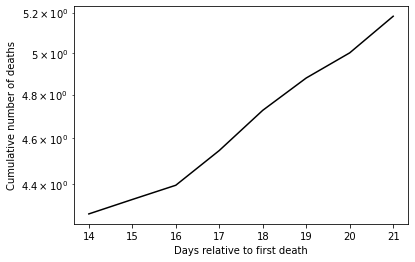

In [16]:
loc_String = '2'
fstr = PdfPages('predict_mult'+loc_String+'.pdf')
fig = plt.figure()
ax = plt.subplot(111)
ave_array = []
record = model
time_to_fit = record['time_to_fit']
tc,shifted_times,idiotA,idiotB,idiotC,idiotD = record['time_courses'],record['shifted_times'],record['idiot'+loc_String+'_third_half'],record['idiot'+loc_String+'_third_twothird'],record['idiot'+loc_String+'_quarter_half'],record['idiot'+loc_String+'_quarter_twothird']
for i,lst in enumerate(tc['Inf']):
    shift_le_14 = shifted_times[i]<min(22,time_to_fit + int(loc_String)*record['tplus'])
    shift_ge_0 = shifted_times[i]>=14
    shift_le_14 = np.logical_and(shift_le_14,shift_ge_0)
    ave_array.append(tc['Dead'][i][shift_le_14])
    # if (j==0) and (i==0):
    #     ax.semilogy(shifted_times[i,shift_le_14],(lst[shift_le_14]),'r-',alpha=0.5)
    #     ax.semilogy(shifted_times[i,shift_le_14],(tc['Dead'][i][shift_le_14]),'k-',alpha=0.2)
    # ax.semilogy(shifted_times[i,shift_le_14],(lst[shift_le_14]),'r-',alpha=0.5)
    # ax.semilogy(shifted_times[i,shift_le_14],(tc['Dead'][i][shift_le_14]),'k-',alpha=0.2)
ave_array = np.array(ave_array).mean(axis=0)
ax.semilogy(np.arange(14,22),ave_array,'k-',label='No distancing')
plt.xlabel('Days relative to first death')
plt.ylabel('Cumulative number of deaths')